In [1]:
# Необходимые импорты
import warnings
warnings.simplefilter('ignore')

import numpy as np
import pandas as pd
import random
import time

from numpy import sort

import scipy.stats as stats

import pylab
from pylab import rcParams

import sklearn.linear_model as lm
from sklearn import base
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PolynomialFeatures, LabelEncoder, PowerTransformer
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, RFE, SelectFromModel
from sklearn.feature_selection import SelectFromModel


from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb
import lightgbm as lgbm
import catboost as catb

import seaborn as sns

from matplotlib import pyplot as plt

%matplotlib inline

In [2]:
pd.set_option("display.max_columns", 999)

In [3]:
# Тренировочный и тестовый датасеты
TEST_DATASET_PATH = 'course_project_test.csv'
TRAIN_DATASET_PATH = 'course_project_train.csv'
ANSWER_FILE_PATH = 'IVlasov_predictions.csv'

## Обзор и подготовка тестового датасета

### Основные выводы

Ниже приведен обзор и первичный анализ датасета. Основные выводы, которые были сделаны:
* Датасет разбалансирован приблизительно в 2.5 раза. Необходимо провести балансировку
* Найдена и исправлена опечатка в графе "Home Ownership" ("Have Mortgage" -> "Home Mortgage")
___
* В Annual Income и Credit Score присутствует большое количество пропусков. Annual Income заполним при помощи линейной регрессии, так как этот признак имеет высокую положительную корреляцию с двумя другими признаками: "Month Debt" и "Current Credit Balance"
* Annual Income переведен в признак Salary
* Salary и Current Credit Balance объединены в признак "Salaries in Debt", обозначающий отношение текущего долга к месячной зарплате
* Monthly Debt и Salary объединены в признак "Monthly Debt / Salary", характеризующий, какой процент составляет месячный долг от зарплаты
___
* Tax Liens имеет слишком мало значений отличных от 0. Переведен в бинарный признак с аналогичным названием
* Number of Open Accounts разделен на значения <5, 5-9, 10-14, 15-19, >20. Значения добавлены в Number of Open Accounts bins
___
* Month since last delinquent имеет почти 50% пустых значений. Признак трансформирован в "Years since last delinquent", где пустые значения выделены в отдельную категорию.
* Добавлен бинарный признак "Were last delinquent"
___
* Years of Credit History разделен на значения <5, 5-9, 10-14, 15-19, 20-24, 25-29, >30. Значения добавлены в Years of Credit History bins
* Maximum Open Credit и Current Loan Amount объединены в признак "MOP / CLA", показывающий, насколько большой кредит по отношению к своему максимальному кредиту в прошлом взял человек
* Из Number of Credit Problems создан бинарный признак "Were Credit Problems"
* Из Bankruptcies так же создан бинарный признак "Were Bankruptcies"
___
* Из Purpose сделан бинарный признак "is debt consolidation"
* Категории в Purpose разделены при помощи KFoldTargetEncoder
___
* Term переведен в бинарный признак "Is Long Term"
___
* Часть значений Current Loan Amount ниже, чем Current Credit Balance. Это противоречит логике. Значения поменяны местами.
* Высокие значения в Current Loan Amount (999999999) предположительно означают безлимитный кредит. Добавлен признак "is unlimited", высокие значения снижены до максимального значения колонки за вычетом наблюдений с высокими значениями
___
* В Credit Score присутствуют аномально высокие значения, которые в 10 раз превышают основную выборку. Но по ним хорошо отделяется часть целевых значений. В тестовой выборке распределение похожее.
___
* Денежные признаки переведены в log формат

### Первичный анализ

In [4]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df_test = pd.read_csv(TEST_DATASET_PATH)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
Home Ownership                  7500 non-null object
Annual Income                   5943 non-null float64
Years in current job            7129 non-null object
Tax Liens                       7500 non-null float64
Number of Open Accounts         7500 non-null float64
Years of Credit History         7500 non-null float64
Maximum Open Credit             7500 non-null float64
Number of Credit Problems       7500 non-null float64
Months since last delinquent    3419 non-null float64
Bankruptcies                    7486 non-null float64
Purpose                         7500 non-null object
Term                            7500 non-null object
Current Loan Amount             7500 non-null float64
Current Credit Balance          7500 non-null float64
Monthly Debt                    7500 non-null float64
Credit Score                    5943 non-null float64
Credit Default                  7

In [6]:
df.shape

(7500, 17)

In [7]:
df.head(3)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0


**Распределение переменных в датасете**

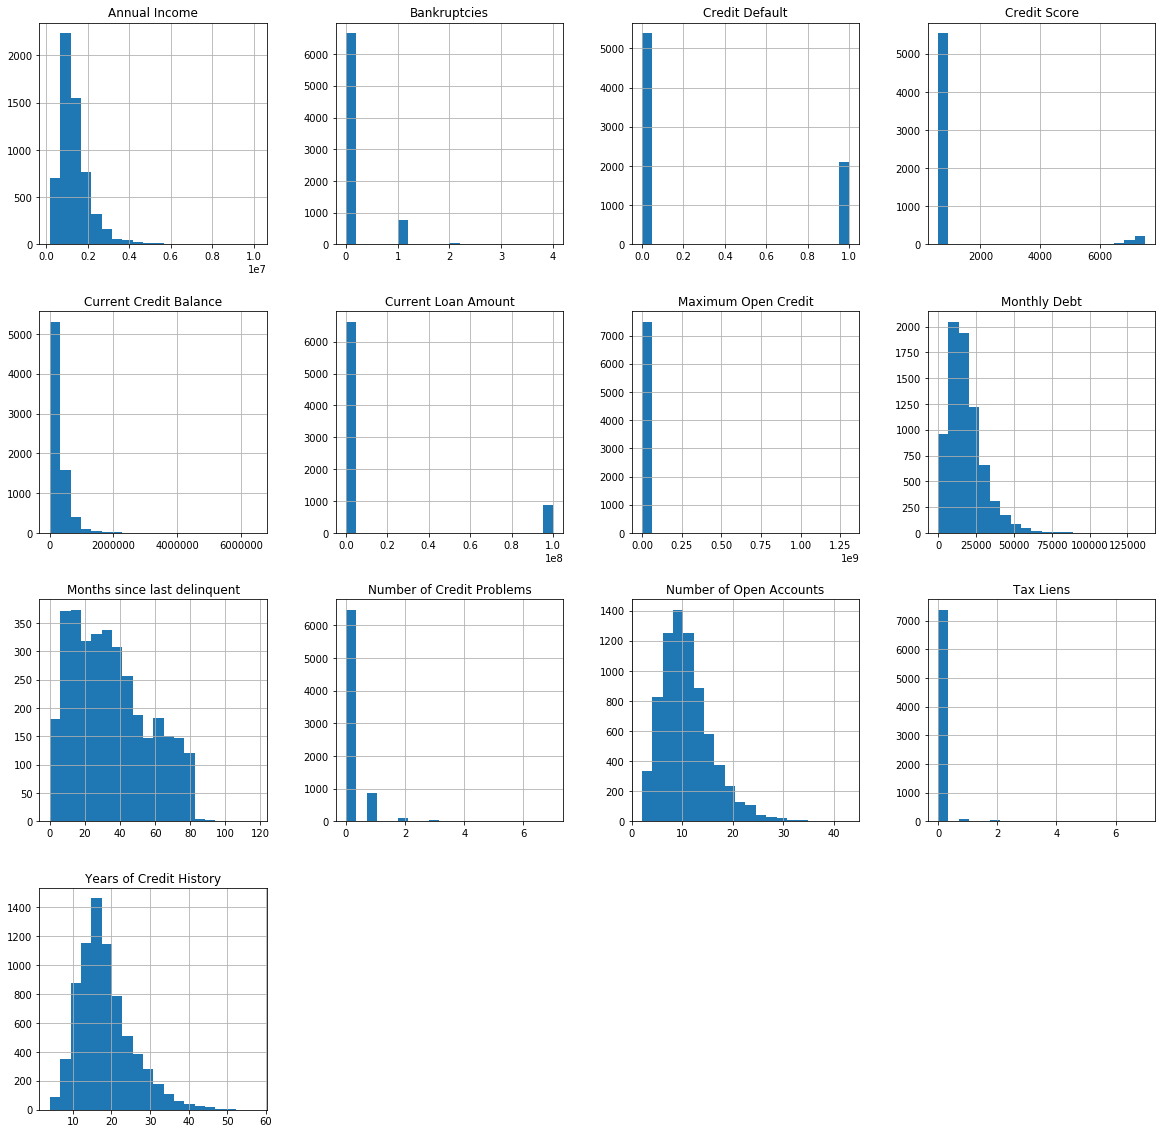

In [8]:
hist = df.hist(figsize=(20, 20), bins=20)

**Обзор количества значений в предположительно категориальных признаках**

In [9]:
for col in df.columns:
    if len(df[col].unique()) < 30:
        print(df[col].value_counts())
        print('-------------\n\n')

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
-------------


10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
-------------


0.0    7366
1.0      83
2.0      30
3.0      10
4.0       6
5.0       2
6.0       2
7.0       1
Name: Tax Liens, dtype: int64
-------------


0.0    6469
1.0     882
2.0      93
3.0      35
4.0       9
5.0       7
6.0       4
7.0       1
Name: Number of Credit Problems, dtype: int64
-------------


0.0    6660
1.0     786
2.0      31
3.0       7
4.0       2
Name: Bankruptcies, dtype: int64
-------------


debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase         

In [10]:
df.groupby(df['Credit Default'])['Purpose'].value_counts()

Credit Default  Purpose             
0               debt consolidation      4290
                other                    468
                home improvements        304
                business loan             74
                buy a car                 72
                medical bills             49
                major purchase            31
                take a trip               27
                buy house                 25
                small business            12
                wedding                   11
                educational expenses       9
                moving                     9
                vacation                   6
1               debt consolidation      1654
                other                    197
                home improvements        108
                business loan             55
                buy a car                 24
                medical bills             22
                small business            14
                ta

**Матрица корреляций** 

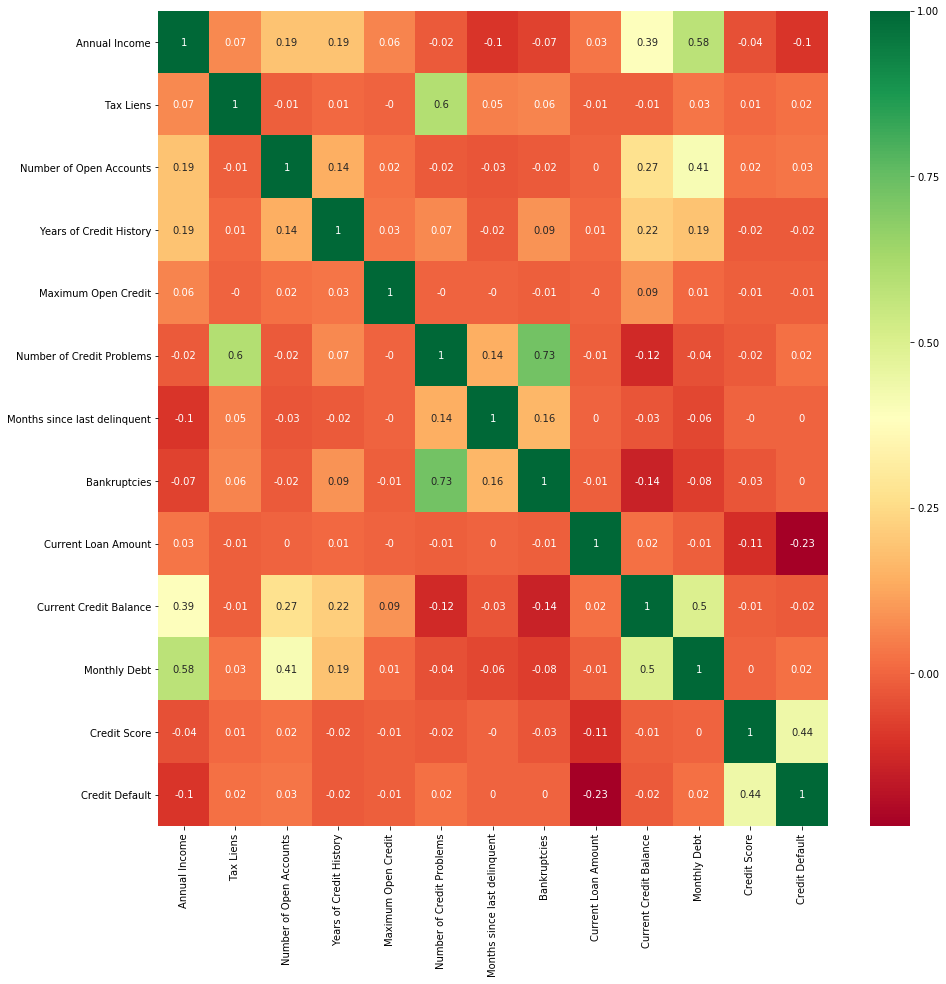

In [11]:
corr_mat_X = df.iloc[:,0:20]  #independent columns
corr_mat_y = df.iloc[:,-1]    #target column i.e price range
#get correlations of each features in dataset
corrmat = df.corr(method='spearman')
top_corr_features = corrmat.index
plt.figure(figsize=(15,15))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr().round(decimals=2),annot=True,cmap="RdYlGn")

**Распределение параметра Credit Score в тренировочном и тестовом датасетах**

[]

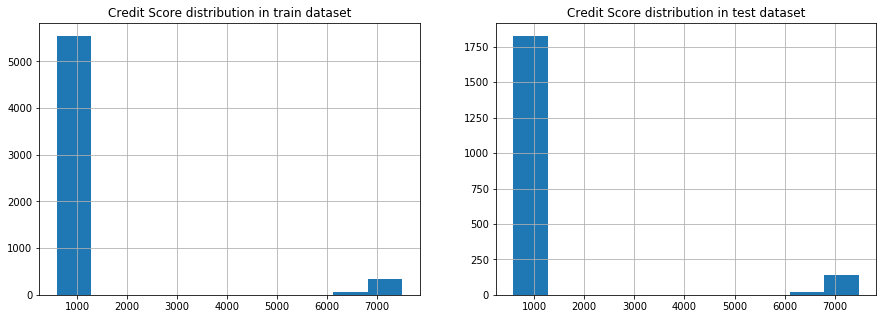

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.hist(df['Credit Score'])
ax2.hist(df_test['Credit Score'])

ax1.set_title('Credit Score distribution in train dataset')
ax2.set_title('Credit Score distribution in test dataset')

ax1.grid(True)
ax2.grid(True)

plt.plot()

[]

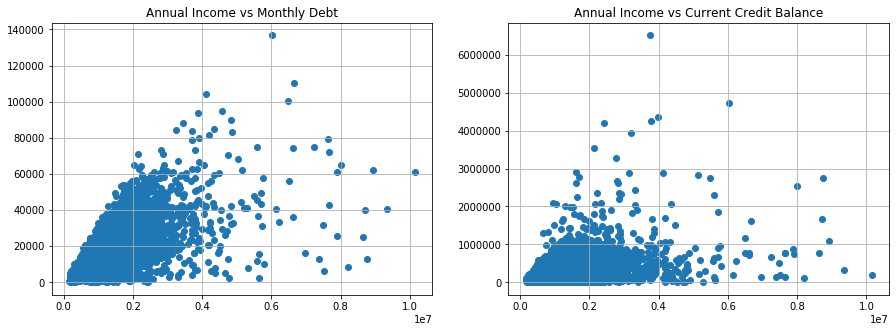

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

ax1.scatter(df['Annual Income'], df['Monthly Debt'])
ax2.scatter(df['Annual Income'], df['Current Credit Balance'])

ax1.set_title('Annual Income vs Monthly Debt')
ax2.set_title('Annual Income vs Current Credit Balance')

ax1.grid(True)
ax2.grid(True)

plt.plot()

**Функции преобразования датасета**

In [14]:
# Home ownership
def home_ownership_t(df):
    df.loc[(df['Home Ownership'] == 'Have Mortgage'), 'Home Ownership'] = 'Home Mortgage'
    return df

def ho_dummies(df):
    dummies = pd.get_dummies(df['Home Ownership'], drop_first=False)
    df = pd.concat([df, dummies], axis=1)
    return df

In [15]:
# Annual Income и Salary
def ann_inc_fillna(df, return_model=False):
    df_copy = df.copy()
    X = df[['Monthly Debt', 'Annual Income']].dropna(axis=0)
    columns_to_modify = ['Monthly Debt']

    low_limit = 0.25
    up_limit = 0.75

    for column in columns_to_modify:
        IQR = X[column].quantile(up_limit) - X[column].quantile(low_limit)
        X = X.loc[(X[column] < X[column].median() + 1.5 * IQR) & (X[column] > X[column].median() - 1.5 * IQR)]

    y = X['Annual Income']
    X.drop('Annual Income', axis=1, inplace=True)
    
    skm = lm.LinearRegression()
    skm.fit(X, y)
    
    values_to_insert = skm.predict(df.loc[df['Annual Income'].isnull(), ['Monthly Debt']])
    df_copy.loc[df['Annual Income'].isnull(), 'Annual Income'] = values_to_insert
    
    if return_model:
        return skm
    else:
        return df_copy

def add_salary(df):
    df['Salary'] = df['Annual Income'] / 12
    df['Monthly Debt / Salary'] = df['Monthly Debt'] / df['Salary']
    df['Salaries in Debt'] = df['Current Credit Balance'] / df['Salary']
    df = df.drop('Annual Income', axis=1)
    return df

In [16]:
# Tax Liens
def tax_liens_to_bin(df):
    df['Tax Liens'] = df['Tax Liens'].apply(lambda x: 1 if x > 0 else 0)
    df['Tax Liens'] = df['Tax Liens'].astype('uint8')
    return df

In [17]:
# Number of open accounts bin
def noa_bin(df):
    cut_bins = [0, 5, 10, 15, 20, 100]
    cut_labels = ['<5', '5-9', '10-14', '15-19', '>20']
    df['Number of Open Accounts bin'] = pd.cut(df['Number of Open Accounts'], bins=cut_bins, labels=cut_labels)
    df['Number of Open Accounts bin'] = df['Number of Open Accounts bin'].astype('object')
    return df

In [18]:
# Month since last delinquent
def msld(df):
    df['Months since last delinquent'].fillna(0, inplace=True)
    df['Years since last delinquent']  = df['Months since last delinquent'] // 12
    df['Years since last delinquent'] = df['Years since last delinquent'].astype('int')
    df['Years since last delinquent'] = df['Years since last delinquent'].astype('object')
    df['Were last delinquent'] = df['Months since last delinquent'].apply(lambda x: 1 if x > 0 else 0)
    df['Were last delinquent'] = df['Were last delinquent'].astype('uint8')
    return df

In [19]:
# Years of Credit History
def yoch(df):
    cut_bins = [0, 5, 10, 15, 20, 25, 30, 100]
    cut_labels = ['<5', '5-9', '10-14', '15-19', '20-24', '25-29', '>30']
    df['Years of Credit History bin'] = pd.cut(df['Years of Credit History'], bins=cut_bins, labels=cut_labels)
    df['Years of Credit History bin'] = df['Years of Credit History bin'].astype('object')
    return df

In [20]:
# MOP / CLA
def mop_cla(df):
    df['MOP / CLA'] = df['Maximum Open Credit'] / df['Current Loan Amount']
    return df

In [21]:
# were bankruptcies, were credit problems
def were_features(df):
    df['Were bankruptcies'] = df['Bankruptcies'].apply(lambda x: 1 if x > 0 else 0)
    df['Were credit problems'] = df['Number of Credit Problems'].apply(lambda x: 1 if x > 0 else 0)
    df[['Were bankruptcies', 'Were credit problems']] = df[['Were bankruptcies', 
                                                            'Were credit problems']].astype('uint8')
    return df

In [22]:
# Purpose
class KFoldTargetEncoderTrain(base.BaseEstimator,
                               base.TransformerMixin):
    def __init__(self,colnames,targetName,
                  n_fold=5, verbosity=False,
                  discardOriginal_col=False):
        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)
        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold,
                   shuffle = True, random_state=2019)
        col_mean_name = self.colnames + '_' + 'Kfold_Target_Enc'
        X[col_mean_name] = np.nan
        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].map(X_tr.groupby(self.colnames)
                                     [self.targetName].mean())
            X[col_mean_name].fillna(mean_of_target, inplace = True)
        if self.verbosity:
            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'.format(col_mean_name,self.targetName,                    
                   np.corrcoef(X[self.targetName].values,
                               encoded_feature)[0][1]))
        if self.discardOriginal_col:
            X = X.drop(self.colnames, axis=1)
        return X
    
def cat_feature_target_encode(df, columns, targetName, n_fold, discard, test=False, df_original=0):
    if test:
        for column in columns:
            df_original['Years in current job'].fillna('11', inplace=True)
            target = targetName
            targetc = KFoldTargetEncoderTrain(column, targetName=target, n_fold=n_fold, discardOriginal_col=discard)
            df_original = targetc.fit_transform(df_original)
            test_targetc = KFoldTargetEncoderTest(df_original, column, f'{column}_Kfold_Target_Enc')
            df = test_targetc.fit_transform(df)
    else:
        for column in columns:
            target = targetName
            targetc = KFoldTargetEncoderTrain(column, targetName=target, n_fold=n_fold, discardOriginal_col=discard)
            df = targetc.fit_transform(df)     
    return df



In [23]:
# Purpose
def purp_to_bin(df):
    df['Is_debt_consolidation'] = df['Purpose'].apply(lambda x: 1 if x == 'debt consolidation' else 0)
    df['Is_debt_consolidation'] = df['Is_debt_consolidation'].astype('uint8')
    return df

In [24]:
# Term
def term_to_bin(df):
    df['Term'] = df['Term'].apply(lambda x: 0 if x == 'Short Term' else 1)
    df['Term'] = df['Term'].astype('uint8')
    df = df.rename(columns={'Term': 'Is Long Term'})
    return df

In [25]:
# Current Loan Amount
def cla_change_with_ccb(df):
    cla_values = df.loc[(df['Current Credit Balance'] > df['Current Loan Amount']), 'Current Credit Balance']
    ccb_values = df.loc[(df['Current Credit Balance'] > df['Current Loan Amount']), 'Current Loan Amount']
    indexes = df.loc[(df['Current Credit Balance'] > df['Current Loan Amount'])].index
    
    df.iloc[indexes]['Current Credit Balance'] = ccb_values
    df.iloc[indexes]['Current Loan Amount'] = cla_values
    
    return df

def is_unlim(df):
    values = df['Current Loan Amount'].apply(lambda x: 1 if x == 99999999 else 0)
    df['Is_unlimited'] = values
    df['Is_unlimited'] = df['Is_unlimited'].astype('uint8')
    df.loc[(df['Current Loan Amount'] > 9000000), 'Current Loan Amount'] = df.loc[
        (df['Current Loan Amount'] < 9000000), 'Current Loan Amount'].max()
    return df

In [26]:
def create_log_columns(df, columns, drop_original=True):
    for column in columns:
        df.insert((len(df.columns) - 1), f'{column}_log', np.log(df[column] + 1))
        if drop_original:
            df.drop(column, axis=1, inplace=True)
    return df

In [27]:
def move_target_to_end(df, target = 'Credit Default'):
    target_column = df[target]
    df = df.drop(target, axis=1)
    df = pd.concat([df, target_column], axis=1)
    return df

In [28]:
def fillna_in_df(df, test=False, df_original=0):
    df['Years in current job'].fillna('11', inplace=True)
    df['Bankruptcies'].fillna(0, inplace=True)
    df['Credit Score'].fillna(df['Credit Score'].median(), inplace=True)
    df['Months since last delinquent'].fillna(df['Months since last delinquent'].max() + 1, inplace=True)
    
    if test:
        linear_model = ann_inc_fillna(df_original, return_model=True)
        values_to_insert = linear_model.predict(df.loc[df['Annual Income'].isnull(), ['Monthly Debt']])
        df.loc[df['Annual Income'].isnull(), 'Annual Income'] = values_to_insert
    
    else:
        df = ann_inc_fillna(df)
    return df

**Функция для модификации тестового датасета**

In [29]:
def prepare_train_dataset(df, list_of_transform, target = 'Credit Default', log_cols=True, 
                          columns_to_log = ['Salary', 'Maximum Open Credit', 'Current Credit Balance', 
                                            'Monthly Debt', 'Current Loan Amount'], 
                          target_encode=True):
    
    for transform in list_of_transform:
        df = transform(df)
    
    if log_cols:
        df = create_log_columns(df, columns_to_log, drop_original=True)
    
    if target_encode:
        to_target_encode = ['Years in current job', 'Purpose']
        df = cat_feature_target_encode(df, to_target_encode, target, n_fold=5, discard=False)
    
    df = move_target_to_end(df)
    
    return df
    

In [30]:
list_of_transform = [fillna_in_df, home_ownership_t, ho_dummies, cla_change_with_ccb, add_salary, tax_liens_to_bin, noa_bin, 
                     msld, yoch, mop_cla, were_features, purp_to_bin, term_to_bin, is_unlim]

In [31]:
df_copy = df.copy()
df = prepare_train_dataset(df, list_of_transform, target_encode=True)

In [32]:
df.head()

,Home Ownership,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Is Long Term,Credit Score,Home Mortgage,Own Home,Rent,Monthly Debt / Salary,Salaries in Debt,Number of Open Accounts bin,Years since last delinquent,Were last delinquent,Years of Credit History bin,MOP / CLA,Were bankruptcies,Were credit problems,Is_debt_consolidation,Salary_log,Maximum Open Credit_log,Current Credit Balance_log,Monthly Debt_log,Current Loan Amount_log,Is_unlimited,Years in current job_Kfold_Target_Enc,Purpose_Kfold_Target_Enc,Credit Default
0,Own Home,11,0,11.0,26.3,1.0,119.0,1.0,debt consolidation,0,749.0,0,1,0,0.196993,1.179522,10-14,9,1,25-29,0.006860,1,1,1,10.600998,13.438576,10.766103,8.976515,13.578561,1,0.378738,0.275753,0
1,Own Home,10+ years,0,15.0,15.3,0.0,119.0,0.0,debt consolidation,1,737.0,0,1,0,0.214996,4.621866,10-14,9,1,15-19,4.459897,0,0,1,11.355783,13.982491,12.886573,9.818692,12.487368,0,0.272727,0.275753,1
2,Home Mortgage,8 years,0,11.0,35.0,0.0,119.0,0.0,debt consolidation,0,742.0,1,0,0,0.218006,4.924952,10-14,9,1,>30,0.011824,0,0,1,11.044819,13.983086,12.639120,9.521641,13.578561,1,0.261649,0.280454,0
3,Own Home,6 years,0,8.0,22.5,1.0,119.0,1.0,debt consolidation,0,694.0,0,1,0,0.168999,1.428774,5-9,9,1,20-24,1.214208,1,1,1,11.113790,11.900912,11.470602,9.336003,11.706821,0,0.302053,0.280454,0
4,Rent,8 years,0,13.0,13.6,1.0,119.0,0.0,debt consolidation,0,719.0,0,0,1,0.110993,1.442432,10-14,9,1,10-14,3.066084,0,1,1,11.077357,12.863170,11.443683,8.879194,11.742774,0,0.288889,0.279489,0


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 33 columns):
Home Ownership                           7500 non-null object
Years in current job                     7500 non-null object
Tax Liens                                7500 non-null uint8
Number of Open Accounts                  7500 non-null float64
Years of Credit History                  7500 non-null float64
Number of Credit Problems                7500 non-null float64
Months since last delinquent             7500 non-null float64
Bankruptcies                             7500 non-null float64
Purpose                                  7500 non-null object
Is Long Term                             7500 non-null uint8
Credit Score                             7500 non-null float64
Home Mortgage                            7500 non-null uint8
Own Home                                 7500 non-null uint8
Rent                                     7500 non-null uint8
Monthly Debt / Salary   

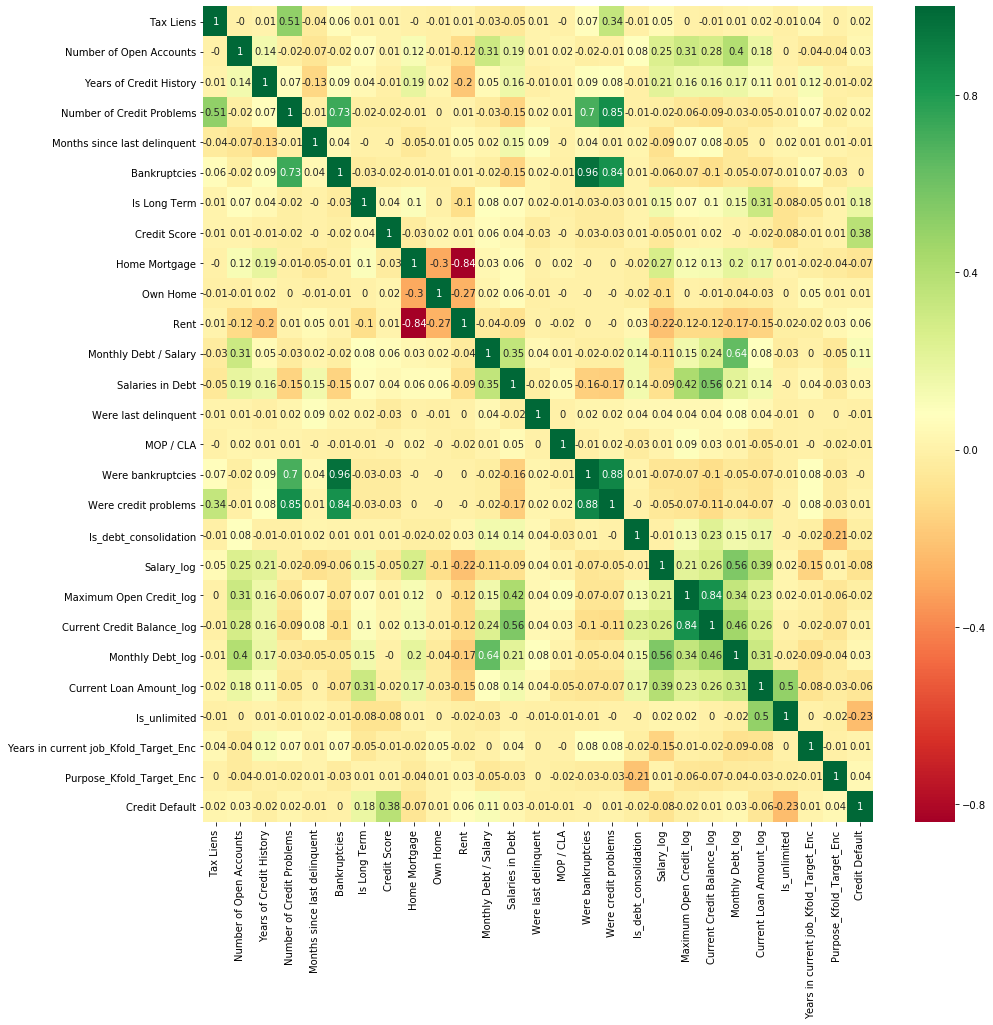

In [34]:
corr_mat_X = df.iloc[:,0:20]  #independent columns
corr_mat_y = df.iloc[:,-1]    #target column i.e price range
#get correlations of each features in dataset
corrmat = df.corr(method='spearman')
top_corr_features = corrmat.index
plt.figure(figsize=(15,15))
#plot heat map
g=sns.heatmap(df[top_corr_features].corr().round(decimals=2),annot=True,cmap="RdYlGn")

### Limit outliers for train df

In [35]:
# Функция удаления выбросов из датасета
def limit_numerical_outliers(df, columns, low_limit, up_limit):
    for column in columns:
        df.loc[(df[column] < df[column].quantile(low_limit)), column] = df[column].quantile(low_limit)
        df.loc[(df[column] > df[column].quantile(up_limit)), column] = df[column].quantile(up_limit)
    return df

In [36]:
# features_to_limit = [column for column in df.columns if df[column].dtype == 'float64']
# list_to_remove_full = ['Number of Open Accounts', 'Years of Credit History', 'Number of Credit Problems', 
#                   'Years since last delinquent', 'Years in current job_Kfold_Target_Enc',
#                  'Purpose_Kfold_Target_Enc']
# list_to_remove = [colname for colname in list_to_remove_full if colname in features_to_limit]

# for column_name in list_to_remove:
#     features_to_limit.remove(column_name)

Ограничивать выбросы не стал, так как алгоритмы на основе деревьев решений устойчивы к ним и для них это скорее потеря информации.

In [37]:
# df = limit_numerical_outliers(df, features_to_limit, 0.02, 0.98)

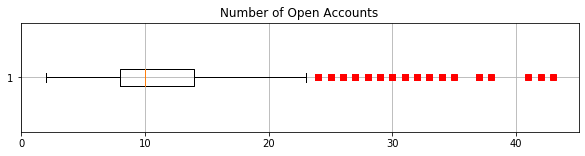

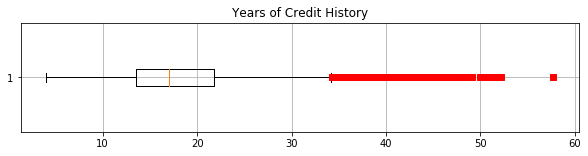

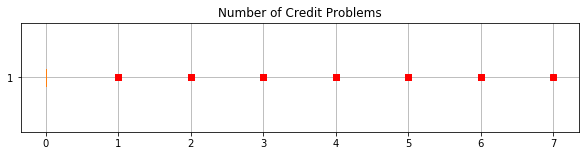

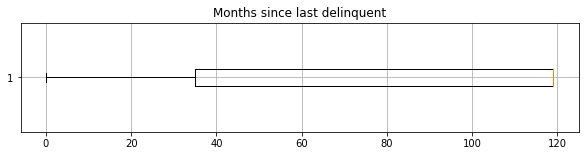

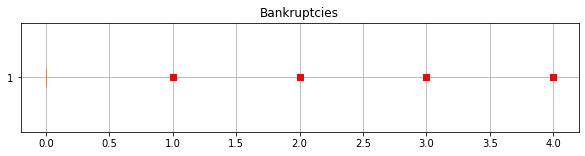

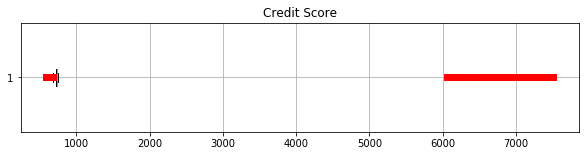

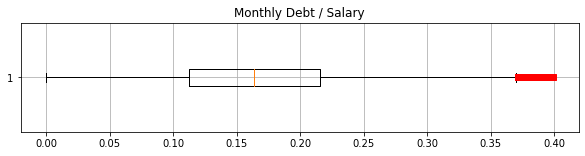

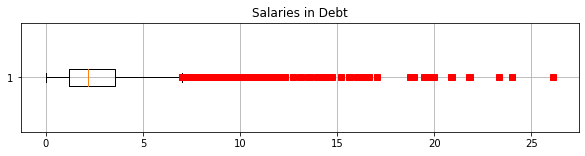

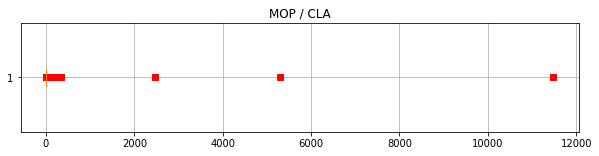

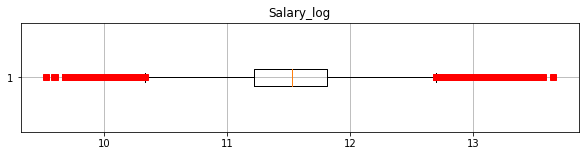

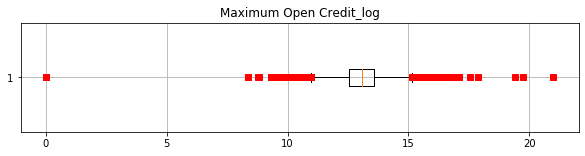

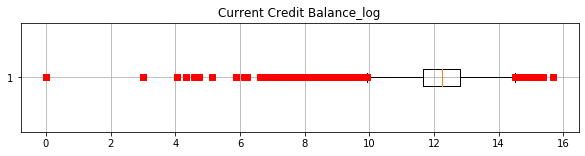

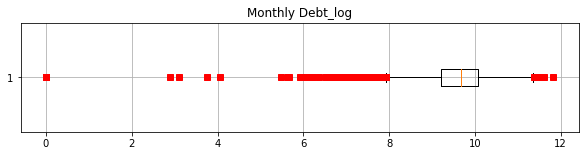

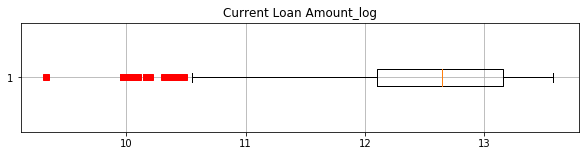

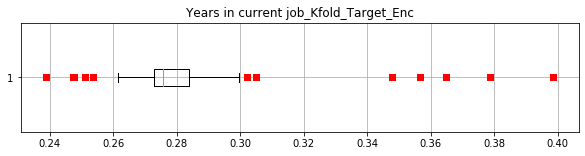

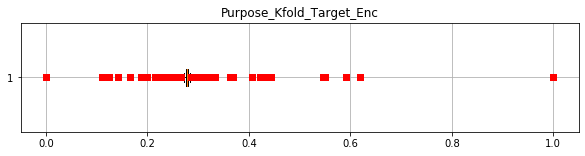

In [38]:
num_features = [column for column in df.columns if (df[column].dtype == 'float64')]

for item in num_features:
    fig, ax = plt.subplots(figsize=(10, 2))
    ax.boxplot(df[item].dropna(), 0, 'rs', 0)
    ax.set_title(str(item))
    ax.grid(True)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 33 columns):
Home Ownership                           7500 non-null object
Years in current job                     7500 non-null object
Tax Liens                                7500 non-null uint8
Number of Open Accounts                  7500 non-null float64
Years of Credit History                  7500 non-null float64
Number of Credit Problems                7500 non-null float64
Months since last delinquent             7500 non-null float64
Bankruptcies                             7500 non-null float64
Purpose                                  7500 non-null object
Is Long Term                             7500 non-null uint8
Credit Score                             7500 non-null float64
Home Mortgage                            7500 non-null uint8
Own Home                                 7500 non-null uint8
Rent                                     7500 non-null uint8
Monthly Debt / Salary   

### Normalization

In [40]:
features_to_norm = [column for column in df.columns if ((df[column].dtype == 'float64'))]

df[features_to_norm] = MinMaxScaler().fit_transform(df[features_to_norm])

### Split and Balancing

In [41]:
# Балансировка датасета по целевому параметру
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 33 columns):
Home Ownership                           7500 non-null object
Years in current job                     7500 non-null object
Tax Liens                                7500 non-null uint8
Number of Open Accounts                  7500 non-null float64
Years of Credit History                  7500 non-null float64
Number of Credit Problems                7500 non-null float64
Months since last delinquent             7500 non-null float64
Bankruptcies                             7500 non-null float64
Purpose                                  7500 non-null object
Is Long Term                             7500 non-null uint8
Credit Score                             7500 non-null float64
Home Mortgage                            7500 non-null uint8
Own Home                                 7500 non-null uint8
Rent                                     7500 non-null uint8
Monthly Debt / Salary   

In [43]:
# CAT_FEATURES = [column for column in X.columns if (X[column].dtype == 'object')]
# SELECTED_NUM_FEATURES = feature_selection_df[feature_selection_df['Total'] > 0]['Feature'].tolist()
# SELECTED_FEATURES = SELECTED_NUM_FEATURES + CAT_FEATURES


In [44]:
X = df
X = X.drop('Credit Default', axis=1)
y = df['Credit Default']

features_for_poly = ['Credit Score', 'Monthly Debt / Salary', 'Salary_log', 'Current Loan Amount_log']

# # pol = PolynomialFeatures(degree=2)
# # poly_features = pol.fit_transform(X[features_for_poly])
# # target_feature_names = pol.get_feature_names(features_for_poly)
# # poly_features = pd.DataFrame(poly_features, columns=target_feature_names)
# # poly_features.drop(features_for_poly, axis=1, inplace=True)

# X = pd.concat([X, poly_features], axis=1)

SELECTED_NUM_FEATURES_XGB = [column for column in X.columns if (X[column].dtype != 'object')]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=21, stratify=y)

In [45]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 32 columns):
Home Ownership                           7500 non-null object
Years in current job                     7500 non-null object
Tax Liens                                7500 non-null uint8
Number of Open Accounts                  7500 non-null float64
Years of Credit History                  7500 non-null float64
Number of Credit Problems                7500 non-null float64
Months since last delinquent             7500 non-null float64
Bankruptcies                             7500 non-null float64
Purpose                                  7500 non-null object
Is Long Term                             7500 non-null uint8
Credit Score                             7500 non-null float64
Home Mortgage                            7500 non-null uint8
Own Home                                 7500 non-null uint8
Rent                                     7500 non-null uint8
Monthly Debt / Salary   

In [46]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, 'Credit Default')

X_train = df_balanced.drop('Credit Default', axis=1)
y_train = df_balanced['Credit Default']

In [47]:
len(X_train.columns)

32

### Learning

In [48]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

**First train and Feature selection**

In [49]:
model = xgb.XGBClassifier()

model = model.fit(X_train[SELECTED_NUM_FEATURES_XGB], y_train)
y_train_pred = model.predict(X_train[SELECTED_NUM_FEATURES_XGB])
y_test_pred = model.predict(X_test[SELECTED_NUM_FEATURES_XGB])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

best_f1 = 0
best_split = 0
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    select_X_train = selection.transform(X_train[SELECTED_NUM_FEATURES_XGB])
    # train model
    selection_model = xgb.XGBClassifier()
    selection_model.fit(select_X_train, y_train)
    # eval model
    select_X_test = selection.transform(X_test[SELECTED_NUM_FEATURES_XGB])
    y_pred = selection_model.predict(select_X_test)
    predictions = [round(value) for value in y_pred]
    f1 = f1_score(y_test, predictions)
    print("Thresh=%.3f, n=%d, F1: %.2f%%" % (thresh, select_X_train.shape[1], f1*100.0))
    
    if f1 > best_f1:
        best_f1 = f1
        best_split = thresh

TRAIN

              precision    recall  f1-score   support

           0       0.75      0.86      0.80      3771
           1       0.79      0.63      0.70      2958

    accuracy                           0.76      6729
   macro avg       0.77      0.75      0.75      6729
weighted avg       0.77      0.76      0.76      6729

TEST

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      1616
           1       0.53      0.51      0.52       634

    accuracy                           0.73      2250
   macro avg       0.67      0.67      0.67      2250
weighted avg       0.73      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1328  288
1                309  325
Thresh=0.000, n=26, F1: 52.13%
Thresh=0.000, n=26, F1: 52.13%
Thresh=0.000, n=26, F1: 52.13%
Thresh=0.000, n=26, F1: 52.13%
Thresh=0.000, n=26, F1: 52.13%
Thresh=0.000, n=26, F1: 52.13%
Thresh=0.000, n=26, F1: 5

In [50]:
important_features = [
    feature
    for feature, weight in zip(SELECTED_NUM_FEATURES_XGB, model.feature_importances_.flatten())
    if np.abs(weight) >= best_split
]

In [51]:
important_features

['Years of Credit History',
 'Is Long Term',
 'Credit Score',
 'Home Mortgage',
 'Monthly Debt / Salary',
 'MOP / CLA',
 'Salary_log',
 'Current Loan Amount_log',
 'Years in current job_Kfold_Target_Enc']

**Parameters search**

In [52]:
# Create parameter grid
parameters = {"learning_rate": [0.005, 0.001],
               "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
               "max_depth": [4, 5],
               "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
               "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
               "reg_alpha": [0, 0.5, 1],
               "reg_lambda": [1, 1.5, 2, 3, 4.5],
               "min_child_weight": [2, 3, 5, 7],
               "n_estimators": [100, 250, 500, 600, 700, 800]}

xgb_rscv = RandomizedSearchCV(xgb.XGBClassifier(tree_method = "exact", scale_pos_weight=1), 
                              param_distributions = parameters, scoring = "f1_micro",
                              cv = 6, verbose = 3, random_state = 40, n_jobs=6, n_iter=30)

# Fit the model
model_xgboost = xgb_rscv.fit(X_train[important_features], y_train)

# Model best estimator
print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
print("Max Features at Split: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
print("Minimum Sum of the Instance Weight Hessian to Make a Child: ",
      model_xgboost.best_estimator_.get_params()["min_child_weight"])
print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])


xgb_class = xgb_rscv.best_estimator_

y_train_pred = xgb_class.predict(X_train[important_features])
y_test_pred = xgb_class.predict(X_test[important_features])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

Fitting 6 folds for each of 30 candidates, totalling 180 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:    5.2s
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:   31.7s
[Parallel(n_jobs=6)]: Done 180 out of 180 | elapsed:   54.4s finished


Learning Rate:  0.005
Gamma:  0.01
Max Depth:  5
Subsample:  0.4
Max Features at Split:  0.8
Alpha:  0
Lamda:  4.5
Minimum Sum of the Instance Weight Hessian to Make a Child:  3
Number of Trees:  800
TRAIN

              precision    recall  f1-score   support

           0       0.73      0.86      0.79      3771
           1       0.76      0.60      0.67      2958

    accuracy                           0.74      6729
   macro avg       0.75      0.73      0.73      6729
weighted avg       0.75      0.74      0.74      6729

TEST

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1616
           1       0.55      0.53      0.54       634

    accuracy                           0.74      2250
   macro avg       0.68      0.68      0.68      2250
weighted avg       0.74      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1337  279
1                297  337


### Predictions

In [53]:
class KFoldTargetEncoderTest(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self,train,colNames,encodedName):
        
        self.train = train
        self.colNames = colNames
        self.encodedName = encodedName
        
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        mean =  self.train[[self.colNames,
                self.encodedName]].groupby(
                                self.colNames).mean().reset_index() 
        
        dd = {}
        for index, row in mean.iterrows():
            dd[row[self.colNames]] = row[self.encodedName]
        X[self.encodedName] = X[self.colNames]
        X = X.replace({self.encodedName: dd})
        return X

In [54]:
def prepare_test_dataset(df, df_original, list_of_transform, target = 'Credit Default', log_cols=True, 
                          columns_to_log = ['Salary', 'Maximum Open Credit', 'Current Credit Balance', 
                                            'Monthly Debt', 'Current Loan Amount'], 
                          target_encode=True):
    
    df = fillna_in_df(df, test=True, df_original=df_original)
    
    for transform in list_of_transform:
        df = transform(df)
    
    if log_cols:
        df = create_log_columns(df, columns_to_log, drop_original=True)
    
    if target_encode:
        to_target_encode = ['Years in current job', 'Purpose']
        df = cat_feature_target_encode(df, to_target_encode, target, n_fold=5, discard=False, test=True, 
                                       df_original=df_original)
    
    return df

In [55]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_original = pd.read_csv(TRAIN_DATASET_PATH)

In [56]:
list_of_transform = [home_ownership_t, ho_dummies, cla_change_with_ccb, add_salary, tax_liens_to_bin, noa_bin, 
                     msld, yoch, mop_cla, were_features, purp_to_bin, term_to_bin, is_unlim]

In [57]:
df_test = prepare_test_dataset(df_test, df_original, list_of_transform, target_encode=True)

In [58]:
# df_test = limit_numerical_outliers(df_test, features_to_limit, 0.02, 0.98)

In [59]:
features_to_norm = [column for column in df_test.columns if ((df_test[column].dtype == 'float64'))]

df_test[features_to_norm] = MinMaxScaler().fit_transform(df_test[features_to_norm])

In [60]:
final_predict = xgb_class.predict(df_test[important_features])
df_test['Credit Default'] = final_predict

In [61]:
df_test['Credit Default'].to_csv(ANSWER_FILE_PATH, index=False, encoding='utf-8')